# 필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.by import By

import requests
from bs4 import BeautifulSoup

import time

import os
from getpass import getpass

from collections import Counter

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from math import sqrt

plt.rc('font', family='Malgun Gothic')

# 웹스크래핑

영화 포스터를 클릭하면 영화 장르와 상영시간 등 상세정보 페이지로 이동한다.
셀레니움으로 클릭해서 웹 요소에 접근하려고 했지만 다양한 문제가 발생했다.
또 ElementClickInterceptedException이라는 클릭하려는 요소가 다른 요소에 의해 가려져 클릭할 수 없는 문제가 발생했다.
이는 스크롤과 같은 동적 요소로 인해 발생하는 것으로 추정된다.
자바스크립트 클릭으로 강제적으로 클릭하고자 하였으나 코드 작동 시간이 너무 길어졌다.
페이지가 로딩되는 것을 하나하나 다 기다려야 하는데 평가한 영화가 700개가 넘어가는데 시간이 너무 오래 걸리는 것이다.

다음과 같은 해결방안으로 이를 해결하였다.
1. 우선 스크롤은 무조건 해야하므로 페이지를 끝까지 스크롤하고 BeautifulSoup로 html 코드를 받아 저장한다.
2. href 속성의 링크를 찾아 그것을 requests로 접근하여 필요한 데이터를 스크래핑 한다.
3. 이는 셀레니움에 비해 확연하게 코드 작동시간이 빨라진다.

## 함수 만들기

In [2]:
def get_movie(url):
    
    options = Options()
    options.add_experimental_option("detach", True)
    
    driver = webdriver.Chrome(options=options)
    driver.implicitly_wait(3)
    
    driver.get(url)
    time.sleep(3)
    
    # 페이지 끝까지 스크롤
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
        time.sleep(0.5)
    
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        
    # HTML 코드 변수에 저장해두기
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    
    driver.quit()

    return soup

In [3]:
def get_movie_detail_infos(soup):
    a_tags = soup.select('li._DV31 > a')
    
    domain_name = 'https://pedia.watcha.com'
    urls = []
    for a_tag in a_tags:
        urls.append(domain_name + a_tag['href'])

    movie_infos = []
    for url in urls:
        movie_page = requests.get(url)
        soup = BeautifulSoup(movie_page.text, 'html.parser')
        
        movie_info_row = []
        movie_title = soup.select_one('h1.QCY16').get_text()
        movie_info_row.append(movie_title)
        
        movie_info_tags = soup.select('div.rLGhk.Zcvzh')[1:]
        
        for movie_info_tag in movie_info_tags:
            movie_info_row.append(movie_info_tag.get_text())
        print(movie_info_row)
        movie_infos.append(movie_info_row)
        
    return movie_infos

In [4]:
def get_movie_title_rating(soup):
    movie_titles = [mn.get_text() for mn in soup.select('div.ZADAQ')]
    movie_ratings = [ms.get_text().split()[2] for ms in soup.select('div.G41oJ')]
    
    return movie_titles, movie_ratings

In [5]:
def make_movie_df_to_excel(movie_titles, movie_ratings, movie_infos, excel_title):
    movie_df = pd.DataFrame(data={'movie_title': movie_titles,
                                         'movie_rating': movie_ratings,
                                         'movie_info': movie_infos})
    movie_df.to_excel(f'data/{excel_title}.xlsx', index=False)
    return movie_df

## 누나가 평가한 영화 정보 스크래핑

In [6]:
if os.path.exists("data/movie_sister.xlsx"):
    print("파일이 존재합니다: data/movie_sister.xlsx")
else:
    url_sister = 'https://pedia.watcha.com/ko-KR/users/nb4xk1kp4vOAz/contents/movies/ratings'
    soup_sister = get_movie(url_sister)
    movie_infos_sister = get_movie_detail_infos(soup_sister)
    movie_titles_sister, movie_ratings_sister = get_movie_title_rating(soup_sister)
    movie_df_sister = make_movie_df_to_excel(movie_titles_sister, movie_ratings_sister, movie_infos_sister, 'movie_sister')

파일이 존재합니다: data/movie_sister.xlsx


In [7]:
movie_sister_original = pd.read_excel('data/movie_sister.xlsx')

In [8]:
movie_sister = movie_sister_original.copy()
movie_sister.head()

,movie_title,movie_rating,movie_info
0,아메리칸 심포니,3.0,"['아메리칸 심포니', '2023 · 다큐멘터리/전기/뮤지컬 · 미국', '1시간 ..."
1,카3: 새로운 도전,4.0,"['카3: 새로운 도전', '2017 · 애니메이션/모험/코미디/가족/스포츠 · 미..."
2,카 2,3.5,"['카 2', '2011 · 애니메이션/스포츠/가족/코미디/모험 · 미국', '1시..."
3,인 디 아일,4.5,"['인 디 아일', '2018 · 드라마 · 독일', '2시간 5분 · 15세']"
4,추락의 해부,4.0,"['추락의 해부', '2023 · 드라마/스릴러 · 프랑스', '2시간 31분 · ..."


## 내가 평가한 영화 정보 스크래핑

In [9]:
if os.path.exists("data/movie_me.xlsx"):
    print("파일이 존재합니다: data/movie_me.xlsx")
else:
    url_me = 'https://pedia.watcha.com/ko-KR/users/WwRqoXQg0vlzB/contents/movies/ratings'
    soup_me = get_movie(url_me)
    movie_infos_me = get_movie_detail_infos(soup_me)
    movie_titles_me, movie_ratings_me = get_movie_title_rating(soup_me)
    movie_df_me = make_movie_df_to_excel(movie_titles_me, movie_ratings_me, movie_infos_me, 'movie_me')

파일이 존재합니다: data/movie_me.xlsx


In [10]:
movie_me_original = pd.read_excel('data/movie_me.xlsx')

In [11]:
movie_me = movie_me_original.copy()
movie_me.head()

,movie_title,movie_rating,movie_info
0,듄: 파트2,3.5,"['듄: 파트2', '2024 · 액션/모험/드라마/SF · 미국, 캐나다', '2..."
1,파묘,3.5,"['파묘', '2024 · 미스터리/스릴러 · 한국', '2시간 14분 · 15세']"
2,서울의 봄,3.0,"['서울의 봄', '2023 · 드라마 · 한국', '2시간 21분 · 12세']"
3,펄,2.0,"['펄', '2022 · 공포/드라마/스릴러 · 캐나다, 미국, 뉴질랜드', '1시..."
4,폭풍의 시간,2.5,"['폭풍의 시간', '2018 · 스릴러/드라마 · 스페인', '2시간 9분 · 1..."


- movie_info 컬럼의 내용을 각 정보에 해당하는 컬럼으로 나눈다. split() 함수를 사용한다.
- 각 데이터프레임을 분석한다.
- 각 데이터프레임에 포함안된 영화 정보를 각각 병합해준다.
- 추천시스템을 모델링한다.

# 데이터 정제

In [12]:
def data_cleaning_from_movie_info(df):
    cleaned_movie_info = df['movie_info'].str[1:-1].str.split("', ").str[1:] # 확인을 위한 용도인 영화 제목은 다시 제외한다.
    
    features = ['개봉년도', '장르', '국가']
    for i, feature in enumerate(features):
        df[feature] = cleaned_movie_info.str[0].str.replace("'", "").str.split(" · ").str[i] # 작은 따옴표 제거 후 분리
    
    features2 = ['상영시간', '관람등급']
    for i, feature2 in enumerate(features2):
        df[feature2] = cleaned_movie_info.str[1].str.replace("'", "").str.split(" · ").str[i]

    return df

In [13]:
movie_me = data_cleaning_from_movie_info(movie_me)
movie_sister = data_cleaning_from_movie_info(movie_sister)

In [14]:
movie_me.drop('movie_info', axis=1, inplace=True)
movie_me.head()

,movie_title,movie_rating,개봉년도,장르,국가,상영시간,관람등급
0,듄: 파트2,3.5,2024,액션/모험/드라마/SF,"미국, 캐나다",2시간 46분,12세
1,파묘,3.5,2024,미스터리/스릴러,한국,2시간 14분,15세
2,서울의 봄,3.0,2023,드라마,한국,2시간 21분,12세
3,펄,2.0,2022,공포/드라마/스릴러,"캐나다, 미국, 뉴질랜드",1시간 43분,청불
4,폭풍의 시간,2.5,2018,스릴러/드라마,스페인,2시간 9분,15세


In [15]:
movie_sister.drop('movie_info', axis=1, inplace=True)
movie_sister.head()

,movie_title,movie_rating,개봉년도,장르,국가,상영시간,관람등급
0,아메리칸 심포니,3.0,2023,다큐멘터리/전기/뮤지컬,미국,1시간 44분,15세
1,카3: 새로운 도전,4.0,2017,애니메이션/모험/코미디/가족/스포츠,미국,1시간 49분,전체
2,카 2,3.5,2011,애니메이션/스포츠/가족/코미디/모험,미국,1시간 53분,전체
3,인 디 아일,4.5,2018,드라마,독일,2시간 5분,15세
4,추락의 해부,4.0,2023,드라마/스릴러,프랑스,2시간 31분,15세


In [16]:
print(movie_sister.shape)
print(movie_me.shape)

(629, 7)
(882, 7)


In [17]:
movie_sister.info()  # 관람등급 결측치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_title   629 non-null    object 
 1   movie_rating  629 non-null    float64
 2   개봉년도          629 non-null    object 
 3   장르            629 non-null    object 
 4   국가            629 non-null    object 
 5   상영시간          629 non-null    object 
 6   관람등급          601 non-null    object 
dtypes: float64(1), object(6)
memory usage: 34.5+ KB


In [18]:
movie_me.info()   # 관람등급 결측치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_title   882 non-null    object 
 1   movie_rating  882 non-null    float64
 2   개봉년도          882 non-null    object 
 3   장르            882 non-null    object 
 4   국가            882 non-null    object 
 5   상영시간          882 non-null    object 
 6   관람등급          851 non-null    object 
dtypes: float64(1), object(6)
memory usage: 48.4+ KB


# Data Analysis

## 각자 시청한 영화 시간

In [19]:
# 둘 다 '낫 세이프 포 워크' 라는 영화의 상영시간 정보가 누락되어 있다.
# 왓챠피디아에 정보가 없어 네이버에서 검색하여 값을 채워넣었다.
movie_me.loc[442, '상영시간'] = '1시간 14분' 
movie_me.loc[442, '관람등급'] = '전체'

movie_sister.loc[497, '상영시간'] = '1시간 14분'
movie_sister.loc[497, '관람등급'] = '전체'

In [20]:
# 총 시청 시간 계산하는 함수
def total_watching_minute(df):
    contain_hour = df.loc[df['상영시간'].str.contains('시간'), '상영시간']
    hour = contain_hour.str.split("시간 ").str[0].astype(int) * 60
    minute = contain_hour.str.split("시간 ").str[1].str.replace("분", "").astype(int)
    
    df['상영시간(분)'] = hour + minute
    
    not_contain_hour = df.loc[~df['상영시간'].str.contains('시간'), '상영시간']
    
    df.loc[df['상영시간(분)'].isnull(), '상영시간(분)'] = not_contain_hour.str.replace("분", "").astype(int)

    return df['상영시간(분)'].sum()

In [21]:
ONE_DAY_MINUTE = 24 * 60
print(f"누나가 영화 보는데 소비한 시간 : 약 {total_watching_minute(movie_sister) / ONE_DAY_MINUTE:.0f} 일")
print(f"내가 영화 보는데 소비한 시간 : 약 {total_watching_minute(movie_me) / ONE_DAY_MINUTE:.0f} 일")

누나가 영화 보는데 소비한 시간 : 약 50 일
내가 영화 보는데 소비한 시간 : 약 72 일


## 평가한 영화 장르 wordcloud 생성

In [22]:
# 쉼표로 구분된 속상 값을 분리하고 개수를 세 wordcloud 생성하는 함수
def make_feature_wordcloud(df, split_str, feature):
    df_copy = df.copy()
    df_copy['splited_feature'] = df_copy[feature].str.split(split_str)
    df_exploded = df_copy.explode('splited_feature')
    feature_count = df_exploded.groupby('splited_feature').size().sort_values(ascending=False)
    feature_count_dict = feature_count.to_dict()
    word_counts = Counter(feature_count_dict)
    
    wordcloud = WordCloud(font_path=r"C:\Windows\malgun.ttf",width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

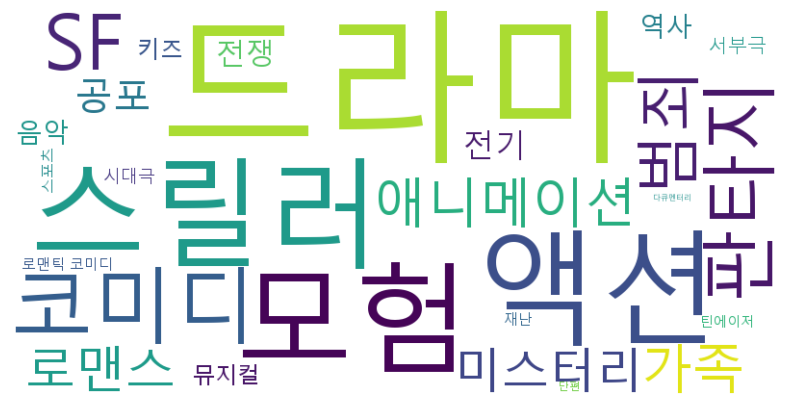

In [23]:
make_feature_wordcloud(movie_me, '/', '장르')

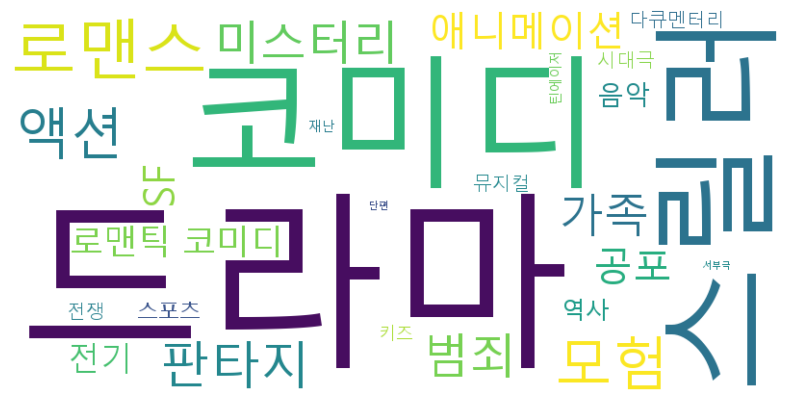

In [24]:
make_feature_wordcloud(movie_sister, '/', '장르')

## 평가한 영화들의 국가 분포

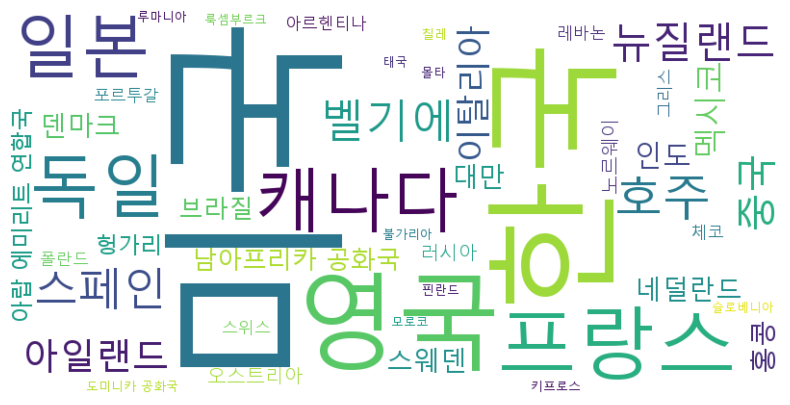

In [25]:
make_feature_wordcloud(movie_me, ', ', '국가')

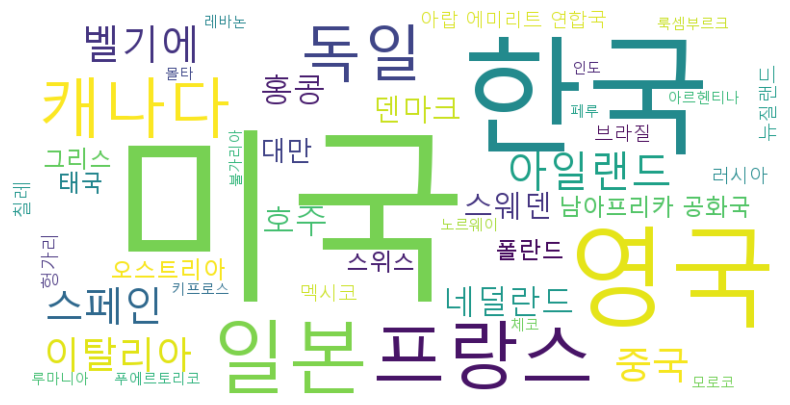

In [26]:
make_feature_wordcloud(movie_sister, ', ', '국가')

## 장르, 국가별 선호도 분석

In [27]:
def cal_score(df, split_str, feature):
    df_copy = df.copy()
    df_copy['splited_feature'] = df_copy[feature].str.split(split_str)
    df_exploded = df_copy.explode('splited_feature')

    # 각 속성별 상위 10개만을 가지고 선호도 분석 (값이 몰려있기 때문)
    movie_counts = df_exploded.groupby('splited_feature').size().sort_values(ascending=False).head(10).to_frame().rename(columns={0:'count'})

    # 각 국가의 영화 수를 100에서 200사이의 값을 갖도록 스케일링
    scaler = MinMaxScaler(feature_range=(100,200))
    movie_counts['scaled_count'] = scaler.fit_transform(movie_counts)
    
    movie_ratings = df_exploded.groupby('splited_feature')['movie_rating'].mean().to_frame()
    movie_ratings = movie_ratings[movie_ratings.index.isin(movie_counts.index)]
    
    movie_merged = movie_counts.merge(movie_ratings, left_index=True, right_index=True, how='left')
    movie_merged['score'] = movie_merged['count'] + movie_merged['movie_rating']*100
    
    return movie_merged.sort_values('score', ascending=False)

In [28]:
me_genre_score_top10 = cal_score(movie_me, '/', '장르')
me_genre_score_top10

,count,scaled_count,movie_rating,score
splited_feature,,,,
드라마,507,200.000000,3.610454,868.045365
액션,272,140.355330,3.488971,620.897059
모험,251,135.025381,3.681275,619.127490
스릴러,247,134.010152,3.471660,594.165992
코미디,205,123.350254,3.556098,560.609756
판타지,173,115.228426,3.690751,542.075145
SF,180,117.005076,3.511111,531.111111
가족,113,100.000000,3.747788,487.778761
애니메이션,117,101.015228,3.653846,482.384615


In [29]:
sister_genre_score_top10 = cal_score(movie_sister, '/', '장르')
sister_genre_score_top10

,count,scaled_count,movie_rating,score
splited_feature,,,,
드라마,408,200.000000,3.785539,786.553922
코미디,208,141.002950,3.685096,576.509615
스릴러,170,129.793510,3.605882,530.588235
로맨스,147,123.008850,3.738095,520.809524
모험,113,112.979351,3.783186,491.318584
액션,103,110.029499,3.635922,466.592233
판타지,85,104.719764,3.723529,457.352941
가족,69,100.000000,3.811594,450.159420
범죄,75,101.769912,3.713333,446.333333


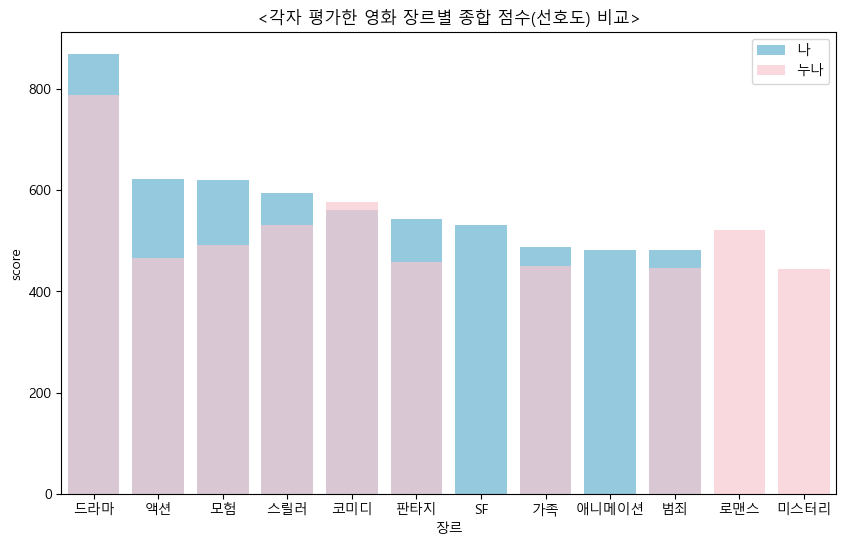

In [30]:
plt.figure(figsize=(10, 6))

sns.barplot(data=me_genre_score_top10, x=me_genre_score_top10.index, y='score', label='나', color='skyblue')
sns.barplot(data=sister_genre_score_top10, x=sister_genre_score_top10.index, y='score', label='누나', color='pink', alpha=0.7)
plt.legend()
plt.xlabel("장르")
plt.title("<각자 평가한 영화 장르별 종합 점수(선호도) 비교>")
plt.show()

In [31]:
me_nat_score_top10 = cal_score(movie_me, ', ', '국가')
me_nat_score_top10

,count,scaled_count,movie_rating,score
splited_feature,,,,
미국,517,200.000000,3.647969,881.796905
한국,235,143.712575,3.253191,560.319149
영국,121,120.958084,3.880165,509.016529
프랑스,66,109.980040,3.409091,406.909091
캐나다,48,106.387226,3.406250,388.625000
독일,48,106.387226,3.406250,388.625000
일본,49,106.586826,3.387755,387.775510
호주,19,100.598802,3.578947,376.894737
벨기에,17,100.199601,3.588235,375.823529


In [32]:
sister_nat_score_top10 = cal_score(movie_sister, ', ', '국가')
sister_nat_score_top10

,count,scaled_count,movie_rating,score
splited_feature,,,,
미국,379,200.000000,3.757256,754.725594
한국,141,135.675676,3.471631,488.163121
영국,100,124.594595,3.830000,483.000000
일본,50,111.081081,3.930000,443.000000
프랑스,43,109.189189,3.813953,424.395349
아일랜드,10,100.270270,4.000000,410.000000
캐나다,32,106.216216,3.718750,403.875000
스페인,9,100.000000,3.888889,397.888889
독일,28,105.135135,3.696429,397.642857


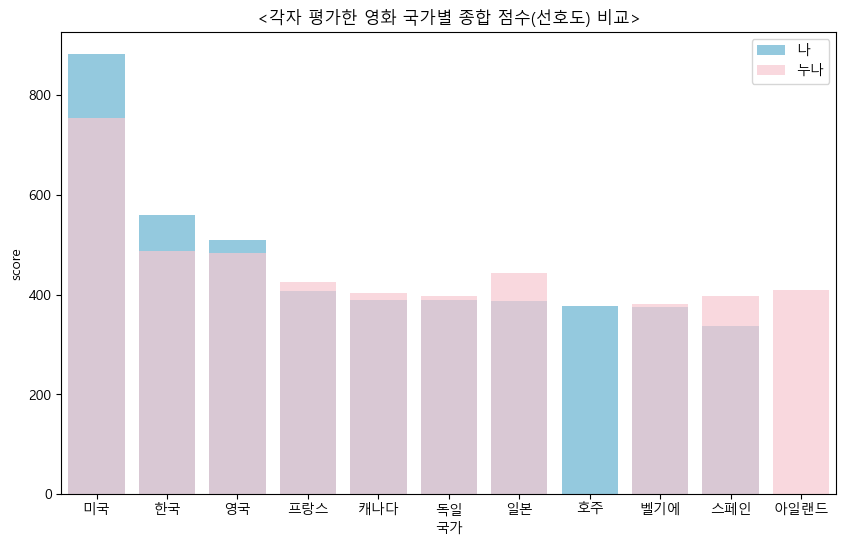

In [33]:
plt.figure(figsize=(10, 6))

sns.barplot(data=me_nat_score_top10, x=me_nat_score_top10.index, y='score', label='나', color='skyblue')
sns.barplot(data=sister_nat_score_top10, x=sister_nat_score_top10.index, y='score', label='누나', color='pink', alpha=0.7)
plt.legend()
plt.xlabel("국가")
plt.title("<각자 평가한 영화 국가별 종합 점수(선호도) 비교>")
plt.show()

## 관람등급 분포

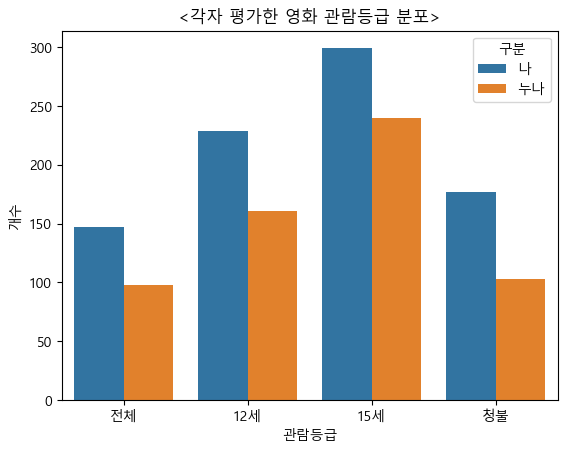

In [34]:
data_me = movie_me['관람등급'].value_counts().to_frame()
data_me['구분'] = '나'

data_sister = movie_sister['관람등급'].value_counts().to_frame()
data_sister['구분'] = '누나'

data = pd.concat([data_me, data_sister])
data
sns.barplot(data=data, x=data.index, y='count', order=['전체', '12세', '15세', '청불'], hue='구분')
plt.ylabel("개수")
plt.title("<각자 평가한 영화 관람등급 분포>")
plt.show()

## 별점 분포

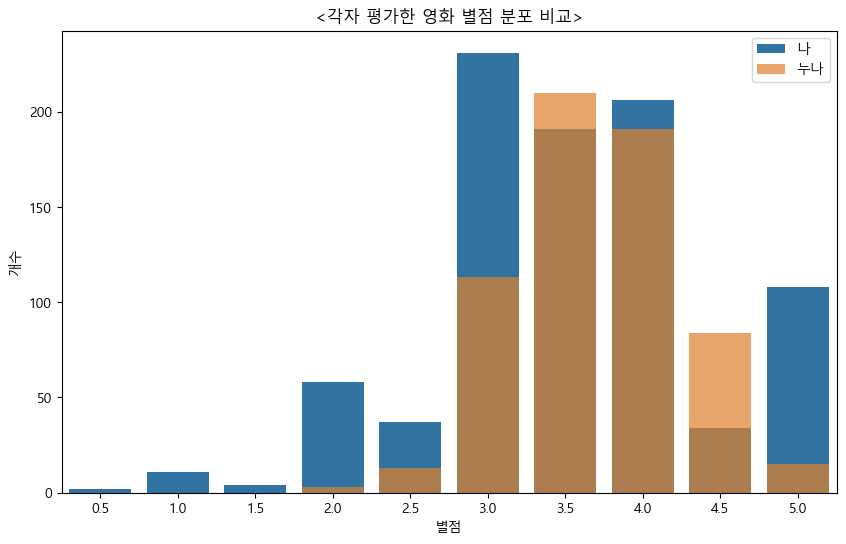

In [35]:
data_me = movie_me['movie_rating'].value_counts().sort_index()
data_sister = movie_sister['movie_rating'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

sns.barplot(data=data_me, dodge=False, label="나")
sns.barplot(data=data_sister, dodge=False, label="누나", alpha=0.7)
plt.ylabel("개수")
plt.xlabel("별점")
plt.legend()
plt.title("<각자 평가한 영화 별점 분포 비교>")

plt.show()

## 개봉년도 분포

In [36]:
movie_me['개봉년도'] = movie_me['개봉년도'].astype(int)
movie_sister['개봉년도'] = movie_sister['개봉년도'].astype(int)

In [37]:
def cut_released_year(df):
    released_counts = df['개봉년도'].value_counts().reset_index()
    bins = [0, 1990, 2000, 2010, 2025]
    labels = ['~ 1990', '1990 ~ 2000', '2000 ~ 2010', '2010 ~ 2024']
    released_counts['released_label'] = pd.cut(released_counts['개봉년도'], bins=bins, labels=labels, right=False)
    return released_counts

def plot_released_year(released_counts, alpha, label):
    for_plot = released_counts.groupby('released_label', observed=True)['count'].sum()
    sns.barplot(for_plot, alpha=alpha, label=label)

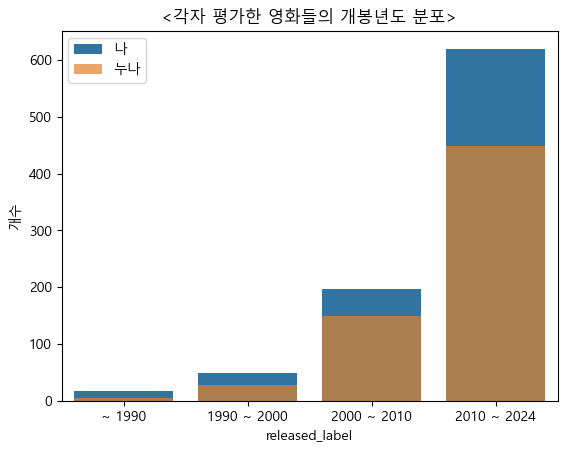

In [38]:
released_counts_me = cut_released_year(movie_me)
released_counts_sister = cut_released_year(movie_sister)

plot_released_year(released_counts_me, 1, '나')
plot_released_year(released_counts_sister, 0.7, '누나')
plt.ylabel("개수")
plt.title("<각자 평가한 영화들의 개봉년도 분포>")
plt.legend()
plt.show()

# 추천시스템 구현

## 서로에게 없는 영화 리스트 찾기

In [39]:
sisters = set(movie_sister['movie_title'])
mine = set(movie_me['movie_title'])

In [40]:
# 누나에게만 있는 영화 리스트
sisters_unique = sisters-mine

In [41]:
# 나에게만 있는 영화 리스트
mine_unique = mine-sisters

## 별점 정답 스크래핑하기

In [42]:
if os.path.exists("data/expected_rating.xlsx"):
    print("파일이 존재합니다: data/movie_me.xlsx")
else:
    # 아이디와 비밀번호 입력받기(보안 상 입력을 가린다.)
    id = getpass("이메일:")
    pw = getpass("비밀번호:")
    
    options = Options()
    options.add_experimental_option("detach", True)
    
    driver = webdriver.Chrome(options=options)
    driver.implicitly_wait(3)
    
    driver.get(url)
    time.sleep(3)
    
    # 로그인 해야 예상 별점을 볼 수 있다.
    driver.find_element(By.CSS_SELECTOR, 'button.CnE27').click()
    driver.find_element(By.CSS_SELECTOR, 'input[type="email"]').send_keys(id)
    driver.find_element(By.CSS_SELECTOR, 'input[type="password"]').send_keys(pw)
    driver.find_element(By.CSS_SELECTOR, 'button[type="submit"]').click()
    
    # 페이지 끝까지 스크롤
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
        time.sleep(0.5)
    
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    
    # 누나만 시청한 영화들을 클릭하여 예상별점을 가져온다.
    sisters_unique = list(sisters_unique)
    expected_rating = []
    for movie in sisters_unique:
        link = driver.find_element(By.CSS_SELECTOR, f'a[title="{movie}"]')
        driver.execute_script("arguments[0].click();", link)
        time.sleep(0.5)
        expected_rating.append(driver.find_element(By.CSS_SELECTOR, 'div.QCY16').text)
        driver.back()
        time.sleep(0.5)
        
    driver.quit()

    # 데이터 프레임 생성
    df = pd.DataFrame({'movie_title': sisters_unique, 'expected_rating': expected_rating})
    df.to_excel('data/expected_rating.xlsx', index=False)

파일이 존재합니다: data/movie_me.xlsx


In [43]:
expected_rating_origin = pd.read_excel('data/expected_rating.xlsx')

In [44]:
expected_rating = expected_rating_origin.copy()
expected_rating.head()

,movie_title,expected_rating
0,마이어로위츠 이야기 (제대로 고른 신작),3.7
1,녹턴,3.6
2,안경,3.3
3,마고 앳 더 웨딩,3.1
4,디스터비아,3.4


## 모든 장르 컬럼 만들고 해당되면 1 채워넣기

In [45]:
def add_genre_columns(df):
    all_genres = set(genre for genres in df["장르"] for genre in genres.split('/'))
    
    # 각 장르를 컬럼으로 추가하고 값을 0으로 초기화
    for genre in all_genres:
        df[genre] = 0
    
    # 각 행에 대해 해당 장르에 값을 1로 설정
    for index, row in df.iterrows():
        for genre in row["장르"].split('/'):
            df.at[index, genre] = 1
    
    # 장르 컬럼 삭제
    df = df.drop(columns=["장르"])

    return df

## 예측 모델을 위한 데이터 준비

In [46]:
sisters_unique_df = movie_sister[movie_sister['movie_title'].isin(sisters_unique)]
sisters_unique_df.loc[:, 'movie_rating'] = np.nan
sisters_unique_df.head()

,movie_title,movie_rating,개봉년도,장르,국가,상영시간,관람등급,상영시간(분)
0,아메리칸 심포니,NaN,2023,다큐멘터리/전기/뮤지컬,미국,1시간 44분,15세,104.0
1,카3: 새로운 도전,NaN,2017,애니메이션/모험/코미디/가족/스포츠,미국,1시간 49분,전체,109.0
2,카 2,NaN,2011,애니메이션/스포츠/가족/코미디/모험,미국,1시간 53분,전체,113.0
4,추락의 해부,NaN,2023,드라마/스릴러,프랑스,2시간 31분,15세,151.0
5,퓨리오사: 매드맥스 사가,NaN,2024,액션/모험/SF,호주,2시간 28분,15세,148.0


In [47]:
movie_me_new = pd.concat([movie_me, sisters_unique_df], ignore_index=True)
movie_me_new

,movie_title,movie_rating,개봉년도,장르,국가,상영시간,관람등급,상영시간(분)
0,듄: 파트2,3.5,2024,액션/모험/드라마/SF,"미국, 캐나다",2시간 46분,12세,166.0
1,파묘,3.5,2024,미스터리/스릴러,한국,2시간 14분,15세,134.0
2,서울의 봄,3.0,2023,드라마,한국,2시간 21분,12세,141.0
3,펄,2.0,2022,공포/드라마/스릴러,"캐나다, 미국, 뉴질랜드",1시간 43분,청불,103.0
4,폭풍의 시간,2.5,2018,스릴러/드라마,스페인,2시간 9분,15세,129.0
...,...,...,...,...,...,...,...,...
1179,시라노; 연애조작단,NaN,2010,로맨틱 코미디/드라마,한국,1시간 57분,12세,117.0
1180,악마는 프라다를 입는다,NaN,2006,드라마/코미디,미국,1시간 49분,12세,109.0
1181,레미제라블,NaN,2012,드라마/역사/뮤지컬/로맨스/전쟁,"영국, 미국, 프랑스",2시간 38분,12세,158.0
1182,러브 액츄얼리,NaN,2003,코미디/드라마/로맨스/로맨틱 코미디/가족,"영국, 미국, 프랑스",2시간 10분,청불,130.0


In [48]:
movie_me_new = add_genre_columns(movie_me_new)

## Lasso 모델로 별점 예측하기

In [49]:
me_df = movie_me_new.drop(['개봉년도', '국가', '상영시간', '관람등급', '상영시간(분)'], axis=1)

movie_rating = me_df.pop('movie_rating')

# wanted_loc = me_df.columns.get_loc('모험') + 1
wanted_loc = len(me_df.columns)

me_df.insert(wanted_loc, 'movie_rating', movie_rating)
me_df.head()

,movie_title,가족,로맨틱 코미디,틴에이저,공포,재난,코미디,뮤지컬,다큐멘터리,전기,...,movie_rating,스릴러,단편,역사,미스터리,판타지,액션,전쟁,범죄,시대극
0,듄: 파트2,0,0,0,0,0,0,0,0,0,...,3.5,0,0,0,0,0,1,0,0,0
1,파묘,0,0,0,0,0,0,0,0,0,...,3.5,1,0,0,1,0,0,0,0,0
2,서울의 봄,0,0,0,0,0,0,0,0,0,...,3.0,0,0,0,0,0,0,0,0,0
3,펄,0,0,0,1,0,0,0,0,0,...,2.0,1,0,0,0,0,0,0,0,0
4,폭풍의 시간,0,0,0,0,0,0,0,0,0,...,2.5,1,0,0,0,0,0,0,0,0


In [51]:
def lasso_predict_rating(df):
    X = df[~df['movie_rating'].isnull()].drop('movie_rating', axis=1).set_index('movie_title')
    y = df.loc[~df['movie_rating'].isnull(), 'movie_rating']
    
    polynomial_transformer = PolynomialFeatures(4)  # 4 차항 변형기
    polynomial_features = polynomial_transformer.fit_transform(X.values)
    features = polynomial_transformer.get_feature_names_out(X.columns)
    X = pd.DataFrame(polynomial_features, columns=features) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
    
    lasso = Lasso(max_iter=5000)
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # 최적의 alpha 값
    best_alpha = grid_search.best_params_['alpha']
    print(f'최적의 alpha 값: {best_alpha}')
    
    # 최적의 alpha 값으로 모델 학습
    model = Lasso(alpha=best_alpha, max_iter=5000)
    model.fit(X_train, y_train)
    
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    mse = mean_squared_error(y_train, y_train_predict)
    
    print("training set에서 성능")
    print("-----------------------")
    print(f'오차: {sqrt(mse)}')
    
    mse = mean_squared_error(y_test, y_test_predict)
    
    print("testing set에서 성능")
    print("-----------------------")
    print(f'오차: {sqrt(mse)}')

    return model

In [52]:
model = lasso_predict_rating(me_df)

최적의 alpha 값: 0.01
training set에서 성능
-----------------------
오차: 0.8113210650331055
testing set에서 성능
-----------------------
오차: 0.8501039475166898


In [53]:
# 각자 안 본 영화 예상 별점 계산
def expect_rating(df, model):
    X = df.loc[df['movie_rating'].isnull()].drop('movie_rating', axis=1).set_index('movie_title')
    
    polynomial_transformer = PolynomialFeatures(4)  # 4 차항 변형기를 정의
    polynomial_features = polynomial_transformer.fit_transform(X.values)
    features = polynomial_transformer.get_feature_names_out(X.columns)
    X = pd.DataFrame(polynomial_features, columns=features)  # 다항 입력 변수를 dataframe으로 만들어 준다
    
    lasso_expected_rating = model.predict(X)
    return lasso_expected_rating

In [54]:
lasso_expected_rating = expect_rating(me_df, model)

answer = me_df[me_df['movie_rating'].isnull()].merge(expected_rating, on='movie_title', how='left')['expected_rating']
mse = mean_squared_error(answer, lasso_expected_rating)

print(f"누나는 보고 내가 안 본 영화 만약 본다면 예상되는 별점 계산한 것은 {mse}의 오차를 갖는다.")

누나는 보고 내가 안 본 영화 만약 본다면 예상되는 별점 계산한 것은 0.15983435515509925의 오차를 갖는다.


In [55]:
me_df.loc[me_df['movie_rating'].isnull(), 'lasso_expected'] = lasso_expected_rating

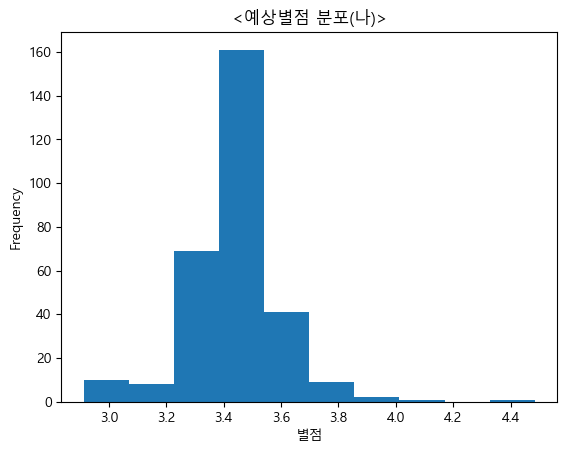

In [56]:
me_df['lasso_expected'].plot(kind='hist')
plt.title("<예상별점 분포(나)>")
plt.xlabel("별점")
plt.show()

In [68]:
me_df.loc[me_df['movie_rating'].isnull(), ['movie_title', 'lasso_expected']].sort_values('lasso_expected', ascending=False).head(10)\
    .rename(columns={'movie_title': '영화제목', 'lasso_expected': '예상별점'})

,영화제목,예상별점
1079,월요일이 사라졌다,4.483754
902,더 킬러,4.103721
1040,미래의 미라이,3.968662
1150,이클립스,3.883569
1076,브레이킹 던 part1,3.850963
1176,뉴 문,3.850963
1149,브레이킹 던 part2,3.850963
1070,마이크롭 앤 가솔린,3.706263
1108,아메리칸 셰프,3.706263
989,크루엘라,3.706263


## 나는 보고 누나는 안 본 영화 만약 누나가 본다면 예상되는 별점 예측하기

In [58]:
me_unique_df = movie_me[movie_me['movie_title'].isin(mine_unique)]
me_unique_df.loc[:, 'movie_rating'] = np.nan
me_unique_df

,movie_title,movie_rating,개봉년도,장르,국가,상영시간,관람등급,상영시간(분)
0,듄: 파트2,NaN,2024,액션/모험/드라마/SF,"미국, 캐나다",2시간 46분,12세,166.0
2,서울의 봄,NaN,2023,드라마,한국,2시간 21분,12세,141.0
3,펄,NaN,2022,공포/드라마/스릴러,"캐나다, 미국, 뉴질랜드",1시간 43분,청불,103.0
4,폭풍의 시간,NaN,2018,스릴러/드라마,스페인,2시간 9분,15세,129.0
5,패러다이스,NaN,2023,액션/SF/스릴러,독일,1시간 56분,청불,116.0
...,...,...,...,...,...,...,...,...
871,나니아 연대기: 새벽 출정호의 항해,NaN,2010,모험/가족/판타지,"미국, 영국",1시간 52분,전체,112.0
873,큐브,NaN,1997,드라마/미스터리/SF/스릴러,캐나다,1시간 30분,청불,90.0
874,의형제,NaN,2010,드라마/액션,한국,1시간 56분,15세,116.0
876,감기,NaN,2013,드라마/모험/액션/재난,한국,2시간 1분,NaN,121.0


In [59]:
movie_sister_new = pd.concat([movie_sister, me_unique_df], ignore_index=True)
movie_sister_new

,movie_title,movie_rating,개봉년도,장르,국가,상영시간,관람등급,상영시간(분)
0,아메리칸 심포니,3.0,2023,다큐멘터리/전기/뮤지컬,미국,1시간 44분,15세,104.0
1,카3: 새로운 도전,4.0,2017,애니메이션/모험/코미디/가족/스포츠,미국,1시간 49분,전체,109.0
2,카 2,3.5,2011,애니메이션/스포츠/가족/코미디/모험,미국,1시간 53분,전체,113.0
3,인 디 아일,4.5,2018,드라마,독일,2시간 5분,15세,125.0
4,추락의 해부,4.0,2023,드라마/스릴러,프랑스,2시간 31분,15세,151.0
...,...,...,...,...,...,...,...,...
1179,나니아 연대기: 새벽 출정호의 항해,NaN,2010,모험/가족/판타지,"미국, 영국",1시간 52분,전체,112.0
1180,큐브,NaN,1997,드라마/미스터리/SF/스릴러,캐나다,1시간 30분,청불,90.0
1181,의형제,NaN,2010,드라마/액션,한국,1시간 56분,15세,116.0
1182,감기,NaN,2013,드라마/모험/액션/재난,한국,2시간 1분,NaN,121.0


In [60]:
movie_sister_new = add_genre_columns(movie_sister_new)

In [61]:
sister_df = movie_sister_new.drop(['개봉년도', '국가', '상영시간', '관람등급', '상영시간(분)'], axis=1)

movie_rating = sister_df.pop('movie_rating')

# wanted_loc = sister_df.columns.get_loc('액션') + 1
wanted_loc = len(sister_df.columns)

sister_df.insert(wanted_loc, 'movie_rating', movie_rating)
sister_df.head()

,movie_title,가족,로맨틱 코미디,틴에이저,공포,재난,코미디,뮤지컬,다큐멘터리,전기,...,스릴러,단편,역사,미스터리,판타지,액션,movie_rating,전쟁,범죄,시대극
0,아메리칸 심포니,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,3.0,0,0,0
1,카3: 새로운 도전,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,4.0,0,0,0
2,카 2,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3.5,0,0,0
3,인 디 아일,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.5,0,0,0
4,추락의 해부,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,4.0,0,0,0


In [62]:
model = lasso_predict_rating(sister_df)

최적의 alpha 값: 0.01
training set에서 성능
-----------------------
오차: 0.5208404996731524
testing set에서 성능
-----------------------
오차: 0.5266476027003922


In [63]:
lasso_expected_rating = expect_rating(sister_df, model)

In [64]:
sister_df.loc[sister_df['movie_rating'].isnull(), 'expected_rating'] = lasso_expected_rating

In [69]:
sister_df.loc[sister_df['movie_rating'].isnull(), ['movie_title', 'expected_rating']].sort_values('expected_rating', ascending=False).head(10)\
    .rename(columns={'movie_title': '영화제목', 'expected_rating': '예상별점'})

,영화제목,예상별점
1137,빅 히어로,3.998692
651,애스터로이드 시티,3.957551
954,더 기버: 기억전달자,3.947272
640,개들의 섬,3.946683
1126,에이 아이,3.936404
629,듄: 파트2,3.914914
1153,혹성탈출: 반격의 서막,3.914914
888,로봇 앤 프랭크,3.908398
699,트랜짓,3.898119
898,맨 프럼 어스,3.898119


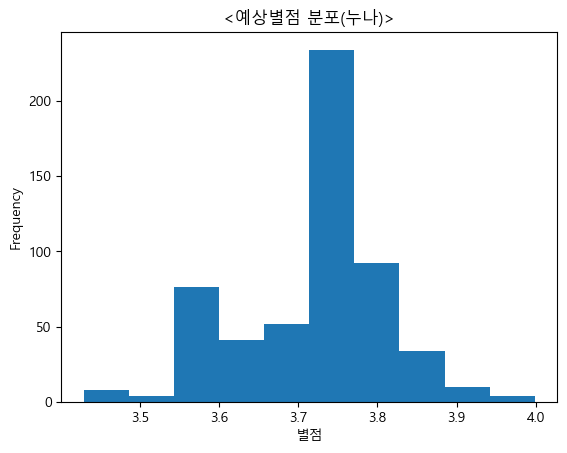

In [66]:
sister_df['expected_rating'].plot(kind='hist')
plt.title("<예상별점 분포(누나)>")
plt.xlabel("별점")
plt.show()